<a href="https://colab.research.google.com/github/christianadriano/PCA_AquacultureSystem/blob/master/PCA_KMeans_Environment_Carcinicultura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd #tables for data wrangling
import numpy as np #basic statistical methods 
import io #for uploading data

#Manual option
from google.colab import files
uploaded = files.upload() #choose file dados_relativizados_carcinicultura.csv



Saving dados_relativizados_centralizados_carcinicultura.csv to dados_relativizados_centralizados_carcinicultura (1).csv


In [33]:
#Upload data from cvs file
df = pd.read_csv(io.StringIO(uploaded['dados_relativizados_centralizados_carcinicultura.csv'].decode('utf-8'))) 
print(df)

    Unnamed: 0         cultura  ...    S19_IR    S20_IE
0            0  Carcinicultura  ... -0.015126 -0.181345
1            1  Carcinicultura  ... -3.007332  1.033912
2            2  Carcinicultura  ...  0.028468 -1.738392
3            3  Carcinicultura  ...  0.168525 -0.540663
4            4  Carcinicultura  ...  0.038207 -0.549427
5            5  Carcinicultura  ...  0.245973 -0.540663
6            6  Carcinicultura  ...  0.068815  1.393230
7            7  Carcinicultura  ... -0.217791 -0.937959
8            8  Carcinicultura  ... -0.385673 -1.043125
9            9  Carcinicultura  ... -0.217791  1.895692
10          10  Carcinicultura  ...  1.097908  0.402913
11          11  Carcinicultura  ...  1.097908  0.402913
12          12  Carcinicultura  ...  1.097908  0.402913

[13 rows x 50 columns]


In [34]:
column_names = df.columns
#Select fatores Ambientais 
feature_names = [name for name in column_names if name.startswith("S")] 

#feature_names = list(df.columns["E1_RRLII":"E13_DM"])
#print(feature_names)
list_names = ['cultivo'] + feature_names
df_cultivo = df[list_names]
df_cultivo.head()



,cultivo,S1_DEL,S2_UMOL,S3_RTUP,S3_RTUP.1,S4_EDGI,S6_PA,S7_PA,S8_TRUAO,S9_TRUP,S10_SLT,S11_CLP,S13_CPT,S14_DR,S15_APS,S16_E,S17_PAC,S18_IG,S19_IR,S20_IE
0,M. rosenbergii - Espirito Santo-,3.435828,-1.066987,-0.199190,-0.326474,-0.382908,1.777040,-1.078517,2.007685,-0.746154,-2.865112,3.253395,-1.077251,-0.632771,3.463754,-0.786190,-0.547723,-1.614284,-0.015126,-0.181345
1,P. vannamei - Sergipe - Semi intensivo,-0.394728,0.671476,3.363483,-0.316466,-0.406004,0.961309,-0.073856,-1.156982,2.590560,-0.797934,-0.662433,0.386925,1.712666,-0.301291,2.243712,-0.547723,2.435664,-3.007332,1.033912
2,L. vannamei - Aquafort,-0.028327,0.529238,-0.523894,-0.601030,-0.593053,-1.407373,1.236002,-0.475027,0.751090,0.649301,0.120472,-1.092631,-0.870714,-0.297869,0.546967,-0.547723,-0.311308,0.028468,-1.738392
3,L. vannamei - Northern,-0.183770,0.671476,-0.384217,-0.505275,-0.534305,-1.264620,-0.073856,1.285567,1.339293,0.649301,0.120472,-0.585091,-0.462812,-0.296728,-0.786190,-0.547723,-0.506681,0.168525,-0.540663
4,L. vannamei - Aquacrusta,-0.368821,0.671476,-0.547476,-0.567991,-0.567760,-1.288072,2.545860,-0.344358,0.184276,0.649301,0.120472,-1.174914,-0.870714,-0.297869,-0.382607,-0.547723,-0.367129,0.038207,-0.549427


In [35]:
#Look at correlations 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_cultivo.corr()

# using a styled panda's dataframe from https://stackoverflow.com/a/42323184/1215012
cmap = 'coolwarm'

def magnify():
    return [dict(selector="th", props=[("font-size", "7pt")]),
            dict(selector="td", props=[('padding', "0em 0em")]),
            dict(selector="th:hover", props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover", 
                 props=[('max-width', '200px'), ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())



,S1_DEL,S2_UMOL,S3_RTUP,S3_RTUP.1,S4_EDGI,S6_PA,S7_PA,S8_TRUAO,S9_TRUP,S10_SLT,S11_CLP,S13_CPT,S14_DR,S15_APS,S16_E,S17_PAC,S18_IG,S19_IR,S20_IE
S1_DEL,1.00,-0.33,-0.08,-0.07,-0.09,0.46,-0.32,0.56,-0.20,-0.82,0.95,-0.31,-0.18,0.99,-0.21,-0.13,-0.50,0.04,-0.13
S2_UMOL,-0.33,1.00,-0.03,-0.90,-0.90,-0.56,0.17,0.34,0.55,0.64,-0.09,-0.62,-0.65,-0.30,-0.44,-0.88,0.20,-0.58,-0.17
S3_RTUP,-0.08,-0.03,1.00,0.13,0.11,0.42,-0.08,-0.43,0.63,-0.35,-0.22,0.31,0.68,-0.06,0.76,0.07,0.68,-0.74,0.34
S3_RTUP.1,-0.07,-0.90,0.13,1.00,1.00,0.40,-0.06,-0.61,-0.43,-0.35,-0.31,0.79,0.80,-0.10,0.60,0.98,0.04,0.54,0.23
S4_EDGI,-0.09,-0.90,0.11,1.00,1.00,0.39,-0.06,-0.61,-0.45,-0.33,-0.32,0.80,0.78,-0.12,0.58,0.98,0.03,0.56,0.23
S6_PA,0.46,-0.56,0.42,0.40,0.39,1.00,-0.34,0.05,-0.33,-0.75,0.22,0.49,0.51,0.51,0.30,0.34,0.01,-0.12,0.38
S7_PA,-0.32,0.17,-0.08,-0.06,-0.06,-0.34,1.00,-0.26,0.13,0.32,-0.23,-0.15,-0.10,-0.31,0.16,-0.04,-0.02,-0.01,-0.24
S8_TRUAO,0.56,0.34,-0.43,-0.61,-0.61,0.05,-0.26,1.00,-0.09,-0.11,0.68,-0.54,-0.71,0.59,-0.81,-0.63,-0.50,-0.06,-0.24
S9_TRUP,-0.20,0.55,0.63,-0.43,-0.45,-0.33,0.13,-0.09,1.00,0.15,-0.11,-0.28,0.05,-0.22,0.32,-0.48,0.49,-0.77,-0.11
S10_SLT,-0.82,0.64,-0.35,-0.35,-0.33,-0.75,0.32,-0.11,0.15,1.00,-0.63,-0.14,-0.40,-0.82,-0.31,-0.28,0.15,0.05,-0.17


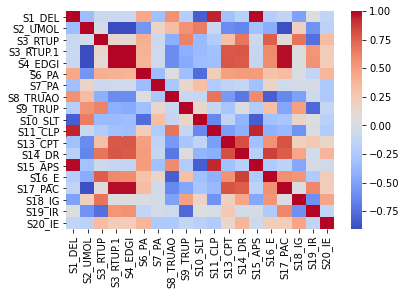

In [36]:
#smaller chart
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')

In [37]:
#check which ones are statiscally significant
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

p_values = calculate_pvalues(df_cultivo)


In [38]:
#Plot p-values
def highlight_significant(val):
    '''
    highlight in blue only the statistically significant cells
    '''
    color = 'blue' if val < 0.05 else 'grey'
    return 'color: %s' % color

p_values.style.applymap(highlight_significant)

,S1_DEL,S2_UMOL,S3_RTUP,S3_RTUP.1,S4_EDGI,S6_PA,S7_PA,S8_TRUAO,S9_TRUP,S10_SLT,S11_CLP,S13_CPT,S14_DR,S15_APS,S16_E,S17_PAC,S18_IG,S19_IR,S20_IE
S1_DEL,0.000000,0.266300,0.784700,0.814100,0.773300,0.116900,0.283100,0.048900,0.517200,0.000600,0.000000,0.301200,0.552200,0.000000,0.496900,0.667900,0.081200,0.889600,0.671000
S2_UMOL,0.266300,0.000000,0.921400,0.000000,0.000000,0.045000,0.579600,0.249200,0.049300,0.017300,0.776900,0.023900,0.016900,0.317300,0.128200,0.000100,0.522700,0.039100,0.581000
S3_RTUP,0.784700,0.921400,0.000000,0.666500,0.729500,0.155800,0.807500,0.145600,0.021800,0.237500,0.467500,0.297100,0.010700,0.839300,0.002400,0.832200,0.010100,0.003700,0.255900
S3_RTUP.1,0.814100,0.000000,0.666500,0.000000,0.000000,0.176700,0.848700,0.026600,0.141200,0.234100,0.304300,0.001300,0.001100,0.741200,0.031300,0.000000,0.902700,0.056500,0.451800
S4_EDGI,0.773300,0.000000,0.729500,0.000000,0.000000,0.188400,0.858400,0.026600,0.118800,0.268300,0.282200,0.001100,0.001500,0.702000,0.037700,0.000000,0.926400,0.046000,0.458900
S6_PA,0.116900,0.045000,0.155800,0.176700,0.188400,0.000000,0.255600,0.880700,0.274600,0.002900,0.462700,0.086100,0.074800,0.072400,0.318600,0.255100,0.969200,0.689900,0.205500
S7_PA,0.283100,0.579600,0.807500,0.848700,0.858400,0.255600,0.000000,0.397300,0.663500,0.287200,0.443200,0.626600,0.732900,0.294800,0.607100,0.895600,0.938400,0.969900,0.423100
S8_TRUAO,0.048900,0.249200,0.145600,0.026600,0.026600,0.880700,0.397300,0.000000,0.762000,0.732200,0.010300,0.057800,0.006800,0.034700,0.000700,0.020600,0.080500,0.848200,0.420300
S9_TRUP,0.517200,0.049300,0.021800,0.141200,0.118800,0.274600,0.663500,0.762000,0.000000,0.628700,0.726600,0.347800,0.859900,0.471100,0.289400,0.096200,0.090500,0.002000,0.720100
S10_SLT,0.000600,0.017300,0.237500,0.234100,0.268300,0.002900,0.287200,0.732200,0.628700,0.000000,0.021400,0.641800,0.180300,0.000600,0.297100,0.354900,0.617700,0.883800,0.569900


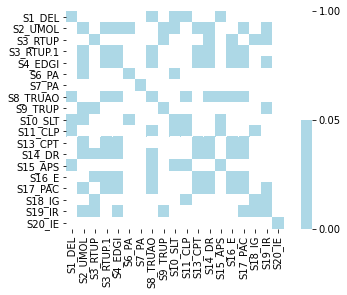

In [39]:
#Smaller plot of p-values
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

np.random.seed(101)
zvals = np.random.rand(100, 100) * 10

# make a color map of fixed colors
cmap_discrete = colors.ListedColormap(['lightblue', 'white'])
bounds=[0,0.05,1]
norm_binary = colors.BoundaryNorm(bounds, cmap_discrete.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(zvals, interpolation='nearest', origin='lower',
                    cmap=cmap_discrete, norm=norm_binary)

sns.heatmap(p_values, xticklabels=p_values.columns, yticklabels=p_values.columns, cmap=cmap_discrete, norm=norm_binary)

**PCA** 
Now we do the PCA 

In [40]:
#Normalize the data to have MEAN==0
from sklearn.preprocessing import StandardScaler

x = df_cultivo.iloc[:,1:].values
x = StandardScaler().fit_transform(x) # normalizing the features
#print(x)


In [41]:
#Run PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_cultivo[['cultivo']]], axis = 1)

['M. rosenbergii - Espirito Santo-'
 'P. vannamei - Sergipe - Semi intensivo' 'L. vannamei - Aquafort'
 'L. vannamei - Northern' 'L. vannamei - Aquacrusta' 'L. vannamei - HM'
 'L. vannamei - Ilha' 'L. vannamei - Carpixe' 'L. vannamei - Marinus'
 'L. vannamei - Aquabrasilis' 'L. vannamei - Aquarium - baixa densid.'
 'L. vannamei - Aquarium - alta densis'
 'L. vannamei - Aquarium-  bifasico']


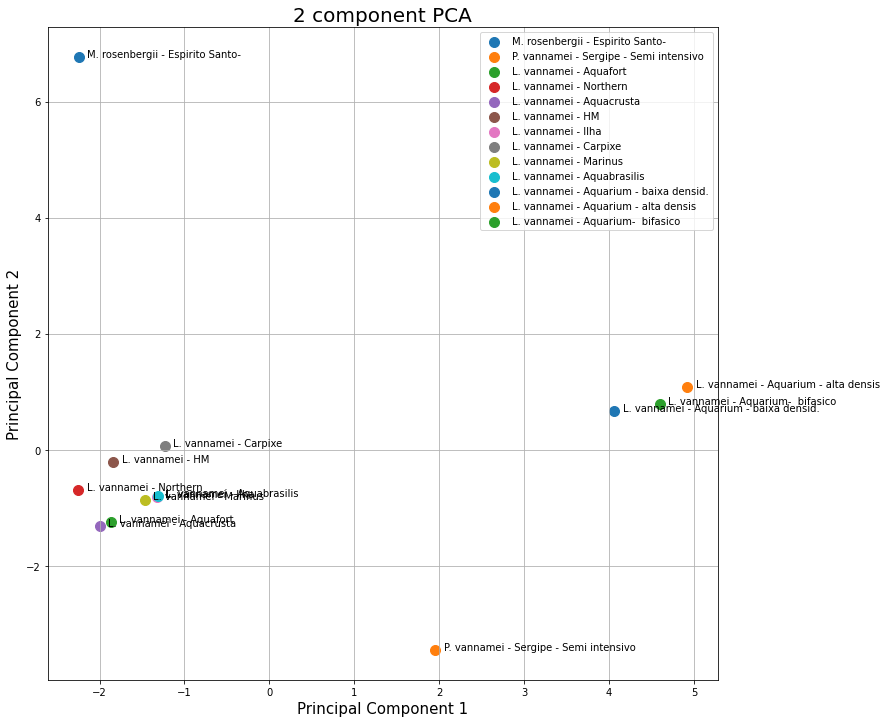

In [43]:
#Visualize results of PCA in Two Dimensions
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()
print(targets)
for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    ax.scatter(x,y,s = 100)
    ax.annotate(target, (x+0.1,y))

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [44]:
variance_list =pca.explained_variance_ratio_
print("variance explained by each component:", variance_list)
print("total variance explained:", sum(variance_list))


variance explained by each component: [0.37910236 0.26626669]
total variance explained: 0.6453690543953596


In [45]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]), 'pc2': list(principalComponents[:,1])}, columns=['cultivo', 'pc1','pc2'])
#df_clustering

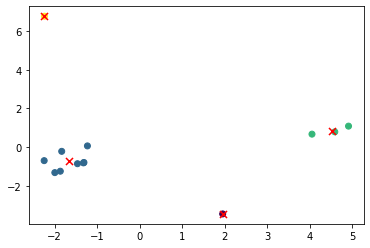

In [65]:
#4 clusters 
from sklearn.cluster import KMeans
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, marker='x', color="red"); # Show the 

In [47]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
0,M. rosenbergii - Espirito Santo-,-2.241994,6.765617,0
2,L. vannamei - Aquafort,-1.868732,-1.242923,1
3,L. vannamei - Northern,-2.248754,-0.696852,1
4,L. vannamei - Aquacrusta,-1.997731,-1.315368,1
5,L. vannamei - HM,-1.835773,-0.216039,1
6,L. vannamei - Ilha,-1.323582,-0.812228,1
7,L. vannamei - Carpixe,-1.230136,0.064758,1
8,L. vannamei - Marinus,-1.464722,-0.855377,1
9,L. vannamei - Aquabrasilis,-1.311939,-0.792314,1
10,L. vannamei - Aquarium - baixa densid.,4.057300,0.673011,2


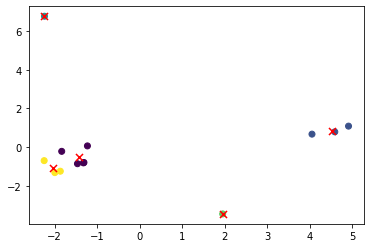

In [62]:
#5 clusters
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50,  marker='x', color="red"); # Show the 


In my view, we have two large clusters and three outliers, as the graph above shows.

In [49]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
5,L. vannamei - HM,-1.835773,-0.216039,0
6,L. vannamei - Ilha,-1.323582,-0.812228,0
7,L. vannamei - Carpixe,-1.230136,0.064758,0
8,L. vannamei - Marinus,-1.464722,-0.855377,0
9,L. vannamei - Aquabrasilis,-1.311939,-0.792314,0
10,L. vannamei - Aquarium - baixa densid.,4.057300,0.673011,1
11,L. vannamei - Aquarium - alta densis,4.917808,1.086724,1
12,L. vannamei - Aquarium- bifasico,4.593910,0.791175,1
0,M. rosenbergii - Espirito Santo-,-2.241994,6.765617,2
1,P. vannamei - Sergipe - Semi intensivo,1.954346,-3.450184,3


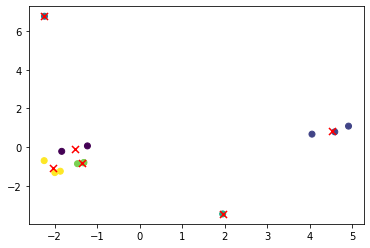

In [61]:
#6 clusters
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, marker='x', color="red"); # Show the 

#7 clusters

In [51]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
5,L. vannamei - HM,-1.835773,-0.216039,0
7,L. vannamei - Carpixe,-1.230136,0.064758,0
10,L. vannamei - Aquarium - baixa densid.,4.057300,0.673011,1
11,L. vannamei - Aquarium - alta densis,4.917808,1.086724,1
12,L. vannamei - Aquarium- bifasico,4.593910,0.791175,1
0,M. rosenbergii - Espirito Santo-,-2.241994,6.765617,2
1,P. vannamei - Sergipe - Semi intensivo,1.954346,-3.450184,3
6,L. vannamei - Ilha,-1.323582,-0.812228,4
8,L. vannamei - Marinus,-1.464722,-0.855377,4
9,L. vannamei - Aquabrasilis,-1.311939,-0.792314,4


In [52]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
5,L. vannamei - HM,-1.835773,-0.216039,0
7,L. vannamei - Carpixe,-1.230136,0.064758,0
10,L. vannamei - Aquarium - baixa densid.,4.057300,0.673011,1
11,L. vannamei - Aquarium - alta densis,4.917808,1.086724,1
12,L. vannamei - Aquarium- bifasico,4.593910,0.791175,1
0,M. rosenbergii - Espirito Santo-,-2.241994,6.765617,2
1,P. vannamei - Sergipe - Semi intensivo,1.954346,-3.450184,3
6,L. vannamei - Ilha,-1.323582,-0.812228,4
8,L. vannamei - Marinus,-1.464722,-0.855377,4
9,L. vannamei - Aquabrasilis,-1.311939,-0.792314,4


Now we analyze 3 Principal Components



In [53]:
#Normalize the data to have MEAN==0
from sklearn.preprocessing import StandardScaler

x = df_cultivo.iloc[:,1:].values
x = StandardScaler().fit_transform(x) # normalizing the features
#print(x)

In [54]:
#Run PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df_cultivo[['cultivo']]], axis = 1)

In [56]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]), 'pc2': list(principalComponents[:,1]),'pc3': list(principalComponents[:,2])}, columns=['cultivo', 'pc1','pc2','pc3'])
#df_clustering

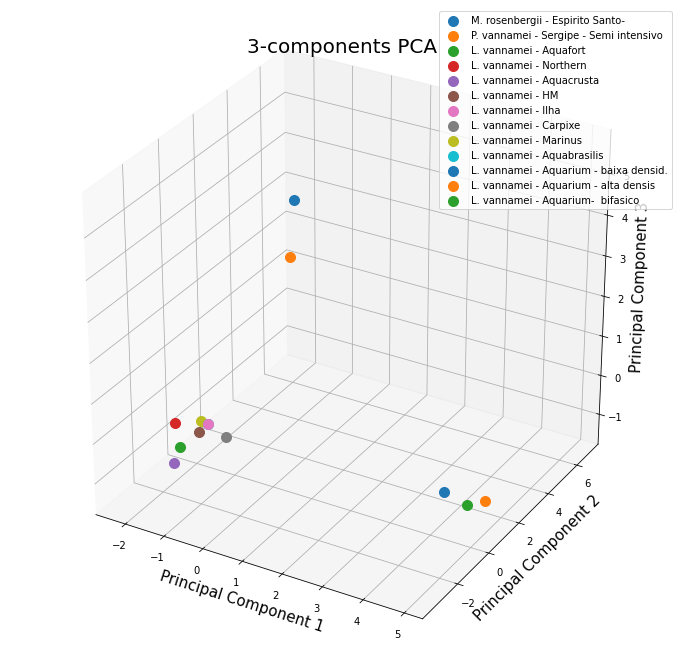

In [57]:
#Visualize results of PCA in Three Dimensions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    
ax.legend(targets)
ax.grid()

Now we search for clusters for 3 principal components

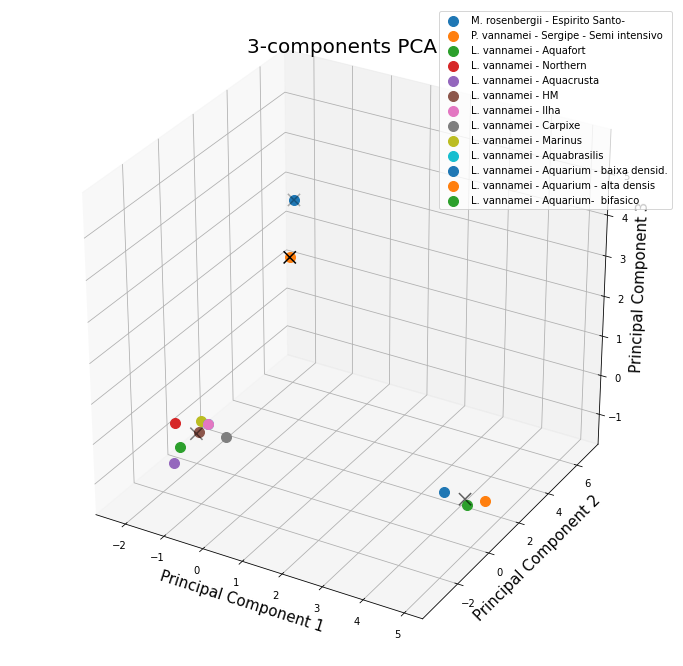

In [58]:
#4 clusters 
from sklearn.cluster import KMeans
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 
   
ax.legend(targets)
ax.grid()

In [66]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]),
                              'pc2': list(principalComponents[:,1]),'pc3': list(principalComponents[:,2])},
                              columns=['cultivo', 'pc1','pc2','pc3'])
#df_clustering

In [67]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')


,cultivo,pc1,pc2,pc3,cluster
1,P. vannamei - Sergipe - Semi intensivo,1.954346,-3.450184,5.559751,0
2,L. vannamei - Aquafort,-1.868732,-1.242923,-0.858962,1
3,L. vannamei - Northern,-2.248754,-0.696852,-0.549292,1
4,L. vannamei - Aquacrusta,-1.997731,-1.315368,-1.278691,1
5,L. vannamei - HM,-1.835773,-0.216039,-0.824082,1
6,L. vannamei - Ilha,-1.323582,-0.812228,-0.265521,1
7,L. vannamei - Carpixe,-1.230136,0.064758,-0.879079,1
8,L. vannamei - Marinus,-1.464722,-0.855377,-0.223099,1
9,L. vannamei - Aquabrasilis,-1.311939,-0.792314,-0.263972,1
10,L. vannamei - Aquarium - baixa densid.,4.057300,0.673011,-0.916374,2


Comparing k-means of PC12 with PC123, we see that the cluster membership changes completely.

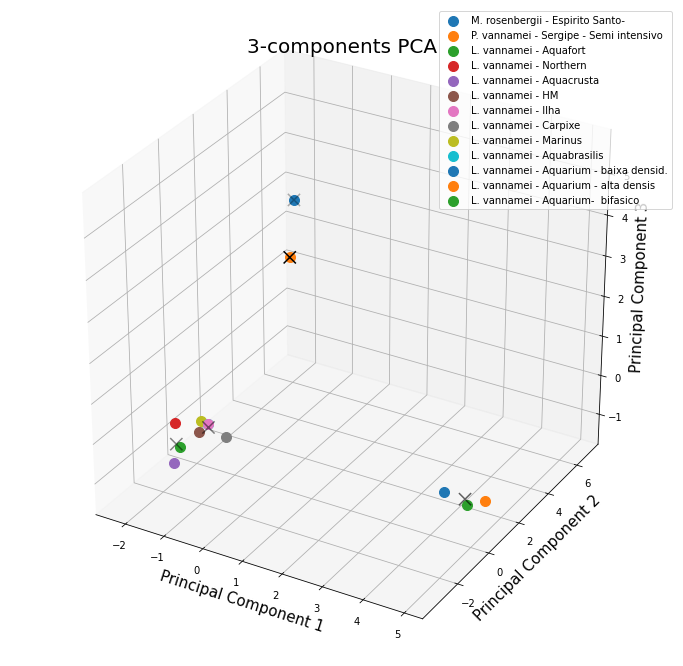

In [68]:
#5 clusters 
from sklearn.cluster import KMeans
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    #ax.annotate(target, (x,y))

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [69]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,pc3,cluster
2,L. vannamei - Aquafort,-1.868732,-1.242923,-0.858962,0
3,L. vannamei - Northern,-2.248754,-0.696852,-0.549292,0
4,L. vannamei - Aquacrusta,-1.997731,-1.315368,-1.278691,0
10,L. vannamei - Aquarium - baixa densid.,4.057300,0.673011,-0.916374,1
11,L. vannamei - Aquarium - alta densis,4.917808,1.086724,-1.027719,1
12,L. vannamei - Aquarium- bifasico,4.593910,0.791175,-1.124000,1
0,M. rosenbergii - Espirito Santo-,-2.241994,6.765617,2.651040,2
1,P. vannamei - Sergipe - Semi intensivo,1.954346,-3.450184,5.559751,3
5,L. vannamei - HM,-1.835773,-0.216039,-0.824082,4
6,L. vannamei - Ilha,-1.323582,-0.812228,-0.265521,4


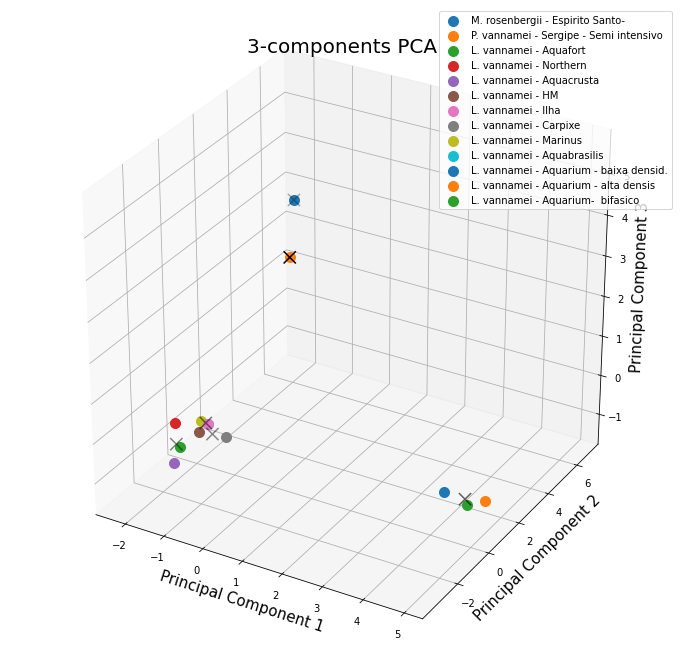

In [70]:
#6 clusters 
from sklearn.cluster import KMeans
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 
    
ax.legend(targets)
ax.grid()

In [71]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,pc3,cluster
2,L. vannamei - Aquafort,-1.868732,-1.242923,-0.858962,0
3,L. vannamei - Northern,-2.248754,-0.696852,-0.549292,0
4,L. vannamei - Aquacrusta,-1.997731,-1.315368,-1.278691,0
10,L. vannamei - Aquarium - baixa densid.,4.057300,0.673011,-0.916374,1
11,L. vannamei - Aquarium - alta densis,4.917808,1.086724,-1.027719,1
12,L. vannamei - Aquarium- bifasico,4.593910,0.791175,-1.124000,1
0,M. rosenbergii - Espirito Santo-,-2.241994,6.765617,2.651040,2
1,P. vannamei - Sergipe - Semi intensivo,1.954346,-3.450184,5.559751,3
5,L. vannamei - HM,-1.835773,-0.216039,-0.824082,4
7,L. vannamei - Carpixe,-1.230136,0.064758,-0.879079,4
